# Deliver With Drones

**Google's Hashcode 2016**

Considering a variety of products distributed through warehouses, the problem consists in deliver these products to client houses through orders. For this there are a given number of drones with a certain maximum payload.

The drones all start in the first specified warehouse and can travel to any point, load products from a warehouse, drop products in the client's house or in another warehouse, or just wait for a few turns.

The idea is to optimize the time that takes to deliver the maximum number of orders possible in the least amount of time.

## 1. Understanding the data

Plotting warehouses (in red circles) and orders (in smaller blue circles) to get a better perspective of the busy day input file.

In [1]:
import matplotlib.pyplot as plt
import numpy as np


# Converting a list of places to a numpy array of 2D positions
def places_location(places):
    locations = [place.location for place in places]

    return np.array(locations)


def plot_simulation(simulation, plot_name=None, order_marker_size=1, warehouse_marker_size=100):
    orders = places_location(simulation.orders)
    warehouses = places_location(simulation.warehouses)
    
    orders_x, orders_y = orders.T
    warehouses_x, warehouses_y = warehouses.T

    plt.scatter(orders_x, orders_y, color='blue', s=order_marker_size, label='order')
    plt.scatter(warehouses_x, warehouses_y, color='red', s=warehouse_marker_size, label='warehouse')

    plt.legend()
    
    if plot_name is not None:
        plt.title(plot_name)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    

def print_commands(commands):
    print('Drone commands')
    for drone in commands:
        for command in drone:
            print(command)

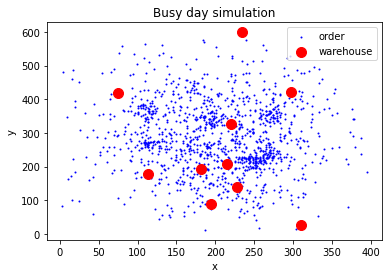

In [2]:
import delivery.input.file_parsing as file_parsing

busy_day_simulation = file_parsing.parse('data/busy_day.in')

plot_simulation(busy_day_simulation, 'Busy day simulation')

Looking at the plot, immediately we recognize that the amount of data is enormous so that it would be difficult to debug in such a complex simulation. Thus, we start our approach using manageable simulations and increasing its complexity.

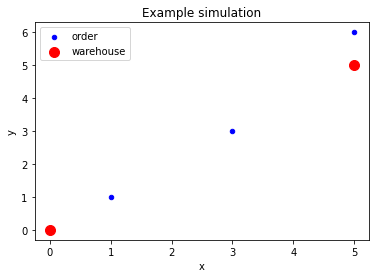

In [3]:
example_simulation = file_parsing.parse('data/example.in')

plot_simulation(example_simulation, 'Example simulation', order_marker_size=20)

## 1.1 Custom simulations

To begin our analysis, we'll check the problems in hand, comprehend their whereabouts, and solve them whenever it is possible. Their algorithmic resolution and analysis come later in the notebook.

### 1.1.1. Obvious simulation

Let's start with an obvious solution to better understand the problem in hand.

The problem specified in _dataobvious.in_ has 3 orders to 3 different houses, 2 of them (order1 and order2) require only one product and the other one (order0) requires 2 products. These 2 products can be found in the same warehouse. To conclude this, there are 3 available drones and their payload is high enough to carry any set of available products.

The trivial and correct solution would be to assign one drone to each delivery, this is, a drone takes care of the order1 product, other takes care of the order2 product, and finally, the last one takes care of the 2 products of order0.

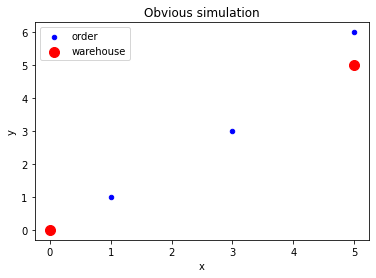

In [4]:
obvious_simulation = file_parsing.parse('data/obvious.in')

plot_simulation(obvious_simulation, 'Obvious simulation', order_marker_size=20)

### 1.1.2. Four orders simulation

The second simulation adds a new order to a distant location from the initial ones (10, 10). This order request 3 products of the same type, all of them can be found in the nearest warehouse.

Since there are 4 orders for 3 drones, the optimal solution is not trivial, yet one thing is certain: given the distance to the new order, and taking into account that only one drone is required, only one drone should take the trip to deliver it.

In the final solution, the same drone also delivered another order in the way to the warehouse that contains the new order's products (very clever). But once again, these results are studied more in detail just below.

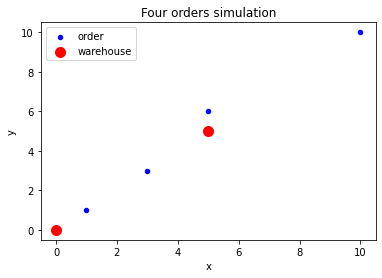

In [5]:
four_orders_simulation = file_parsing.parse('data/fouroo.in')

plot_simulation(four_orders_simulation, 'Four orders simulation', order_marker_size=20)

### 1.1.3. Custom complex simulation

Unlike the others simulation, this simulation does not have a somewhat predictable and crystal clear solution. This simulation was generated randomly and is used to test algorithms and obtain data with them. This simulation is more complex than the previous ones and clearer more straightforward than the busy day simulation, the solution is not obtained immediately and it allows us to collect data in reasonable times.

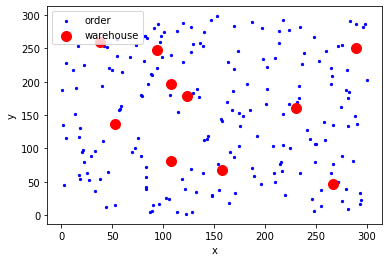

In [6]:
custom_simulation = file_parsing.parse('data/custom.in')

plot_simulation(custom_simulation, order_marker_size=5)

## 2. Genetic Algorithms Approach

The genetic algorithm approach is very versatile in the means that it allow us to specify a set of behaviours. By default, the genetic algorithm follows the following configuration:

- **Selection method:** Roulette
- **Crossover:** One point
- **Generational:** True
- **Population size:** 30
- **Mutation rate:** 0.20
- **Max improveless iterations/generations:** 20

The possible configurations are as follows:

- **Selection method:** Roulette or Tournament (if Tournament the competitors amount needs to be specified)
- **Crossover:** One point or Order
- **Generational:** True or False
- **Population size:** Any positive integer
- **Mutation rate:** Any positive float between 0 and 1
- **Max improveless iterations/generations:** Any positive integer

### 2.1. Solving simple simulations

#### 2.1.1. Obvious simulation

The genetic algorithm configuration for the obvious solution is the following:

- **Selection method:** Tournament with 10 competitors
- **Crossover:** Order
- **Generational:** Default (True)
- **Population size:** Default (30)
- **Mutation rate:** Default(0.20)
- **Max improveless iterations/generations:** 5

One can see in the results that the algorithm assigns one drone to each order (drone 0 to order 1, drone 1 to order 0, and drone 2 to order 2), just as stated in the introduction to the problem above. Since order 0 requests two products of different types, the drone understands that it must pick up both of them and deliver them simultaneously as well, this is, without requiring to travel the deliver distance twice for the same order.

In [7]:
from delivery.algorithm.genetic.genetic import GeneticAlgorithm
from delivery.algorithm.genetic.crossover import OrderCrossover
from delivery.algorithm.genetic.selection import TournamentSelection

order_crossover = OrderCrossover()
tournament_selection = TournamentSelection(10)

algorithm = GeneticAlgorithm(obvious_simulation, max_improveless_iterations=5, crossover=order_crossover, selection_method=tournament_selection, log=True)
result = algorithm.run()

print()

print_commands(algorithm.split_into_commands(result.solution))

Building initial solution
Starting reproduction
Generation 1 with max fitness 256 and global fitness 256
Generation 2 with max fitness 256 and global fitness 256
Generation 3 with max fitness 256 and global fitness 256
Generation 4 with max fitness 256 and global fitness 256
Generation 5 with max fitness 256 and global fitness 256

Drone commands
0 L 1 2 1
0 D 2 2 1
1 L 0 2 1
1 L 0 0 1
1 D 0 2 1
1 D 0 0 1
2 L 0 0 1
2 D 1 0 1


#### 2.1.2. Four orders simulation

Adding another larger order, one can notice that the algorithm assigns that order to a single drone.

This is not done manually. The algorithm is fed one product at a time, it then groups the products from the same order together to reduce the number of travels.

As stated in the introduction, since the products for the new order are located in the warehouse in the middle of the map, and the drones' starting position is in the warehouse in the corner, this particular solution assigns an order that can be completed on the way to the warehouse in the middle to the drone that delivers the new order.

In [8]:
simulation = file_parsing.parse("data/fouroo.in")

algorithm.simulation = simulation
algorithm.max_improveless_iterations=15
result = algorithm.run()

print()

print_commands(algorithm.split_into_commands(result.solution))

Building initial solution
Starting reproduction
Generation 1 with max fitness 292 and global fitness 268
Generation 2 with max fitness 301 and global fitness 292
Generation 3 with max fitness 304 and global fitness 301
Generation 4 with max fitness 304 and global fitness 304
Generation 5 with max fitness 304 and global fitness 304
Generation 6 with max fitness 304 and global fitness 304
Generation 7 with max fitness 304 and global fitness 304
Generation 8 with max fitness 304 and global fitness 304
Generation 9 with max fitness 304 and global fitness 304
Generation 10 with max fitness 304 and global fitness 304
Generation 11 with max fitness 304 and global fitness 304
Generation 12 with max fitness 304 and global fitness 304
Generation 13 with max fitness 304 and global fitness 304
Generation 14 with max fitness 304 and global fitness 304
Generation 15 with max fitness 304 and global fitness 304
Generation 16 with max fitness 304 and global fitness 304
Generation 17 with max fitness 30

### 4. Results

In [9]:
import pandas as pd
import matplotlib

def read_results_file(results_filename):
    dataframe = pd.read_csv(f'results/{results_filename}', delimiter=';')
    
    return dataframe

def plot_results(x, y_list, x_label=None, y_label=None, line_labels=None, plot_name=None):
    matplotlib.rc('figure', figsize=(50, 5))
    
    for index, y in enumerate(y_list):
        label = str(index) if line_labels is None else line_labels[index]
        plt.plot(x, y, label=label)
        
    plt.legend()
    
    plt.xticks(np.arange(0, len(x) * 10, 250))

    if plot_name is not None:
        plt.title(plot_name)

    if x_label is not None:
        plt.xlabel(x_label)
        
    if y_label is not None:
        plt.ylabel(y_label)
    
    plt.show()

### 4.1. Genetic Algorithms

#### 4.1.1. Custom simulation

The configuration used to run the genetic algorithm for the custom simulation is the following:

- **Selection method:** Tournament with 15 competitors
- **Crossover:** Order
- **Generational:** Default (True)
- **Population size:** Default (30)
- **Mutation rate:** 0.15
- **Max improveless iterations/generations:** 150

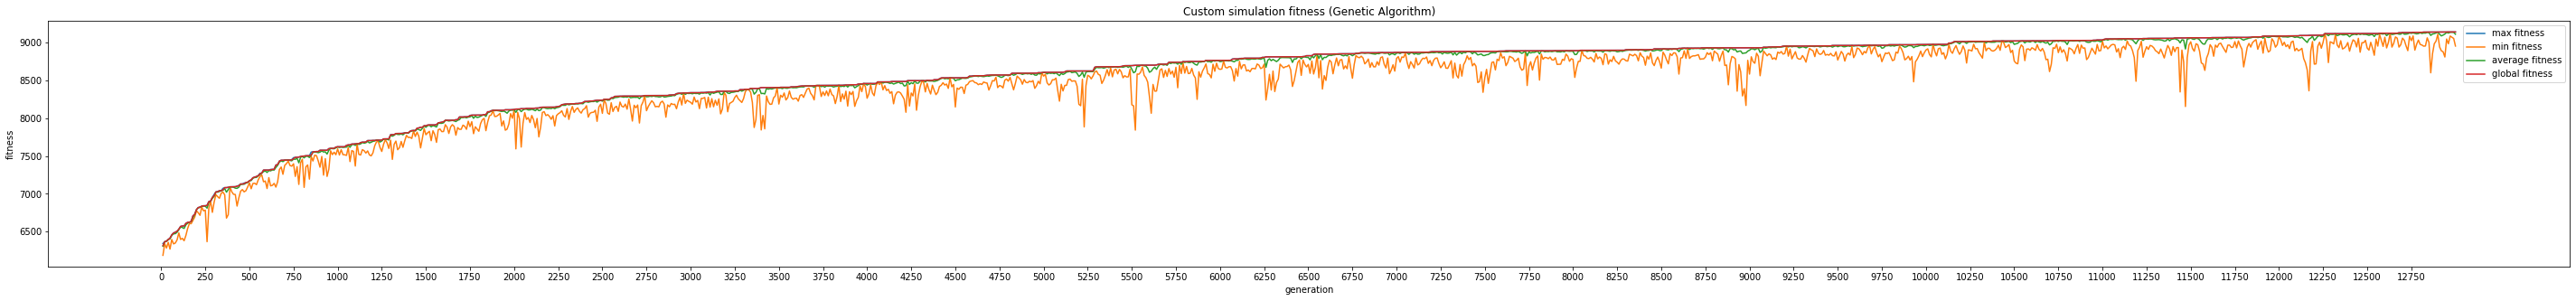

In [10]:
custom_simulation_dataframe = read_results_file('results_0.0828527.log')

custom_simulation_generations = list(custom_simulation_dataframe.iloc[:,0])
custom_simulation_max_fitness = list(custom_simulation_dataframe.iloc[:,1])
custom_simulation_min_fitness = list(custom_simulation_dataframe.iloc[:,2])
custom_simulation_average_fitness = list(custom_simulation_dataframe.iloc[:,3])
custom_simulation_global_fitness = list(custom_simulation_dataframe.iloc[:,4])

x = custom_simulation_generations
y_list = [
    custom_simulation_max_fitness,
    custom_simulation_min_fitness,
    custom_simulation_average_fitness,
    custom_simulation_global_fitness
]

x_label = 'generation'
y_label = 'fitness'
line_labels = [
    'max fitness',
    'min fitness',
    'average fitness',
    'global fitness'
]

plot_results(x, y_list, x_label, y_label, line_labels, plot_name='Custom simulation fitness (Genetic Algorithm)')

#### 4.1.2. Busy day

The configuration used to run the genetic algorithm for the custom simulation is the following:

- **Selection method:** Tournament with 15 competitors
- **Crossover:** Order
- **Generational:** Default (True)
- **Population size:** Default (30)
- **Mutation rate:** 0.2
- **Max improveless iterations/generations:** 200

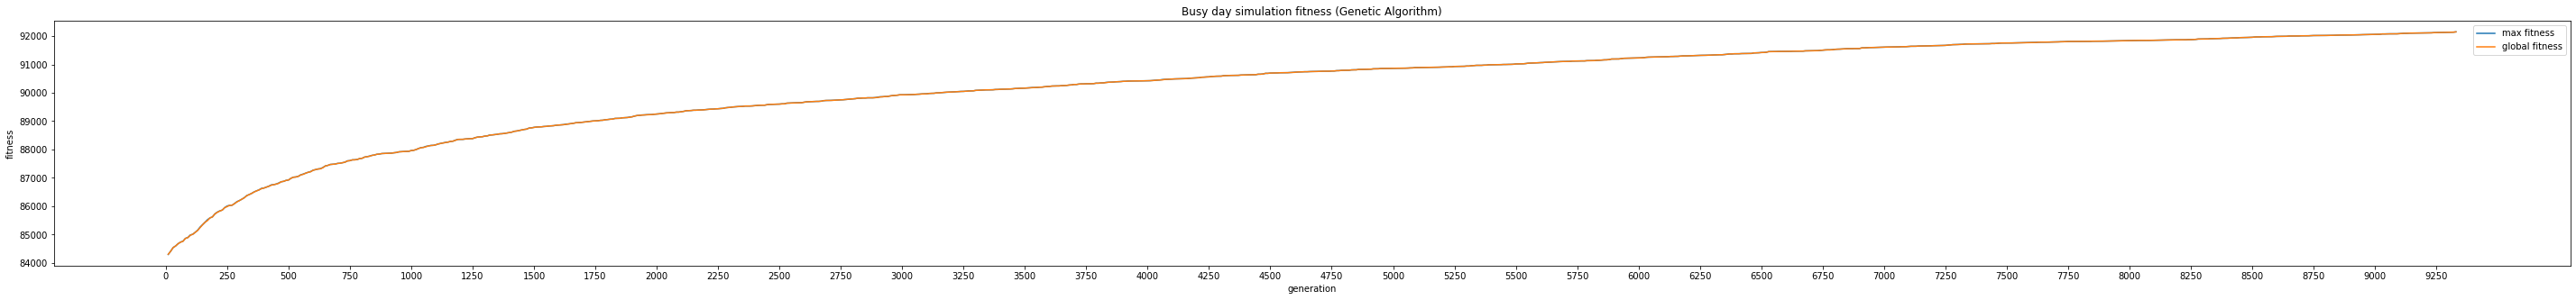

In [11]:
busy_day_1_simulation_dataframe = read_results_file('results_0.0412833.log')

busy_day_1_simulation_generations = list(busy_day_1_simulation_dataframe.iloc[:,0])
busy_day_1_simulation_max_fitness = list(busy_day_1_simulation_dataframe.iloc[:,1])
busy_day_1_simulation_global_fitness = list(busy_day_1_simulation_dataframe.iloc[:,2])

x = busy_day_1_simulation_generations
y_list = [
    busy_day_1_simulation_max_fitness,
    busy_day_1_simulation_global_fitness,
]

x_label = 'generation'
y_label = 'fitness'
line_labels = [
    'max fitness',
    'global fitness'
]

plot_results(x, y_list, x_label, y_label, line_labels, plot_name='Busy day simulation fitness (Genetic Algorithm)')

### 4.2. Local Search

#### 4.2.1. Custom simulation

The configuration used to run the simulated annealing algorithm for the custom simulation is the following:

- **Max Iterations:** 1000
- **Iteration search:** 50 (this means that for each iteration 50 neighbours are going to be evaluated)
- **Initial temperature:** 1000000
- **Temperature schedules:** $a_1=0.95$ and $a_2=0.99$


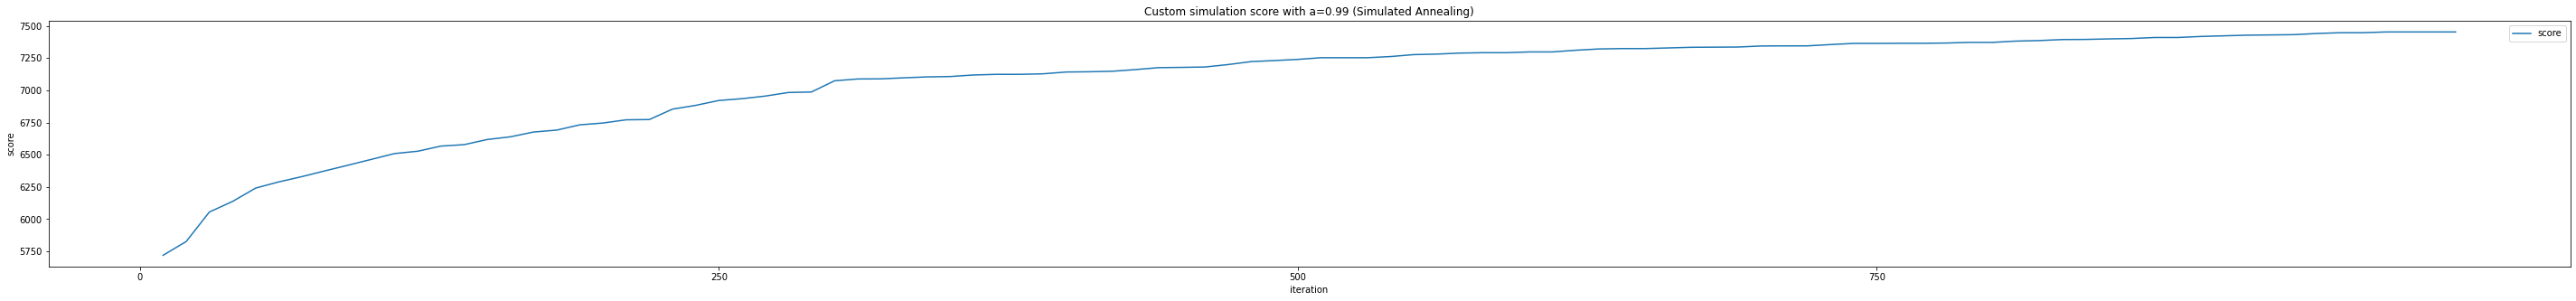

In [12]:
custom_simulation_sa1_dataframe = read_results_file('results_35923.390780807.log')

custom_simulation_sa1_iterations = list(custom_simulation_sa1_dataframe.iloc[:,0])
custom_simulation_sa1_score = list(custom_simulation_sa1_dataframe.iloc[:,1])
custom_simulation_sa1_temperature = list(custom_simulation_sa1_dataframe.iloc[:,2])

x = custom_simulation_sa1_iterations
y_list = [
    custom_simulation_sa1_score,
]

x_label = 'iteration'
y_label = 'score'
line_labels = [
    'score',
]

plot_results(x, y_list, x_label, y_label, line_labels, plot_name='Custom simulation score with a=0.99 (Simulated Annealing)')

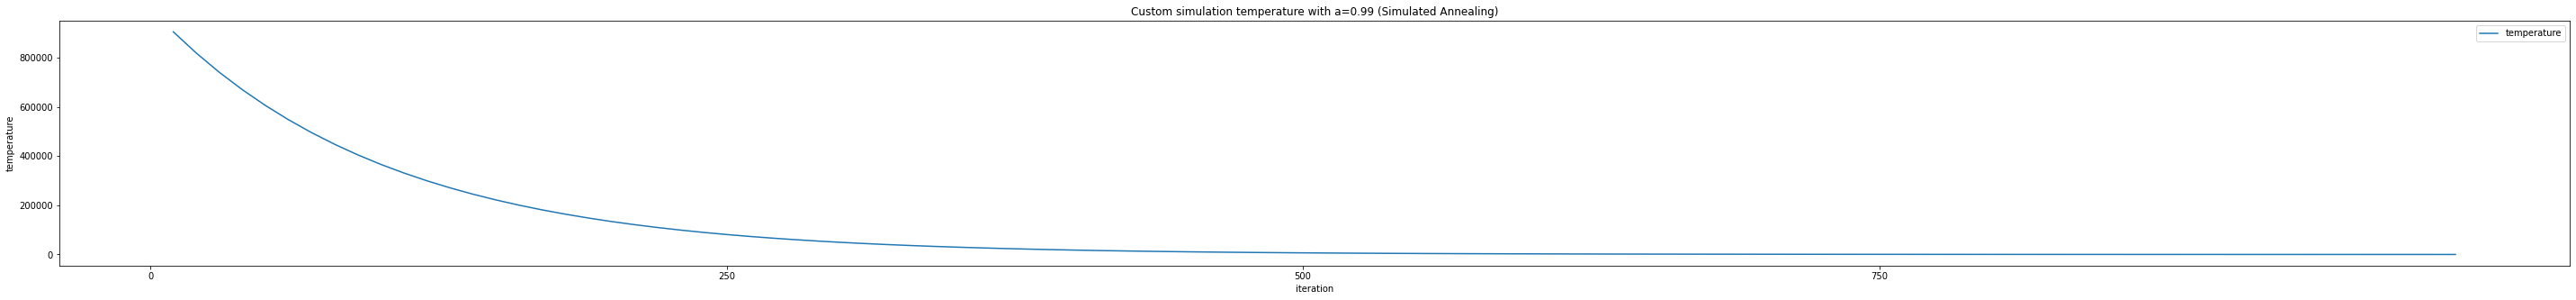

In [13]:
x = custom_simulation_sa1_iterations
y_list = [
    custom_simulation_sa1_temperature,
]

x_label = 'iteration'
y_label = 'temperature'
line_labels = [
    'temperature',
]

plot_results(x, y_list, x_label, y_label, line_labels, plot_name='Custom simulation temperature with a=0.99 (Simulated Annealing)')

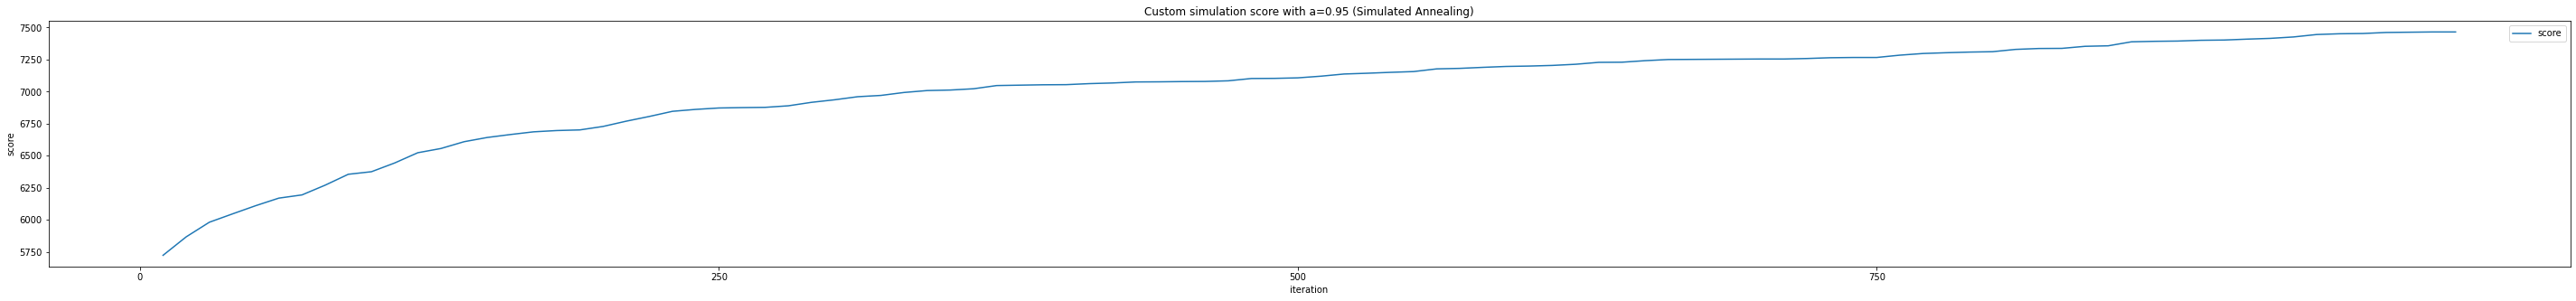

In [14]:
custom_simulation_sa2_dataframe = read_results_file('results_36050.917536528.log')

custom_simulation_sa2_iterations = list(custom_simulation_sa2_dataframe.iloc[:,0])
custom_simulation_sa2_score = list(custom_simulation_sa2_dataframe.iloc[:,1])
custom_simulation_sa2_temperature = list(custom_simulation_sa2_dataframe.iloc[:,2])

x = custom_simulation_sa2_iterations
y_list = [
    custom_simulation_sa2_score,
]

x_label = 'iteration'
y_label = 'score'
line_labels = [
    'score',
]

plot_results(x, y_list, x_label, y_label, line_labels, plot_name='Custom simulation score with a=0.95 (Simulated Annealing)')

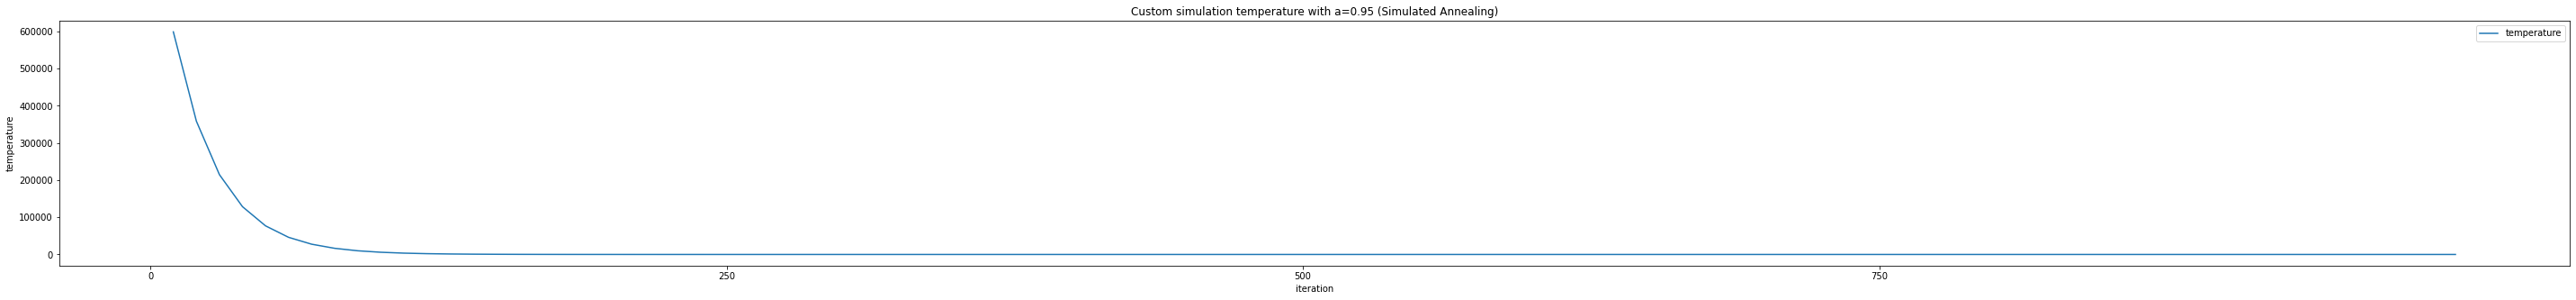

In [15]:
x = custom_simulation_sa2_iterations
y_list = [
    custom_simulation_sa2_temperature,
]

x_label = 'iteration'
y_label = 'temperature'
line_labels = [
    'temperature',
]

plot_results(x, y_list, x_label, y_label, line_labels, plot_name='Custom simulation temperature with a=0.95 (Simulated Annealing)')

The configuration used to run the hill climbing algorithm for the custom simulation is the following:

- **Max Iterations:** 1000
- **Iteration search:** 50

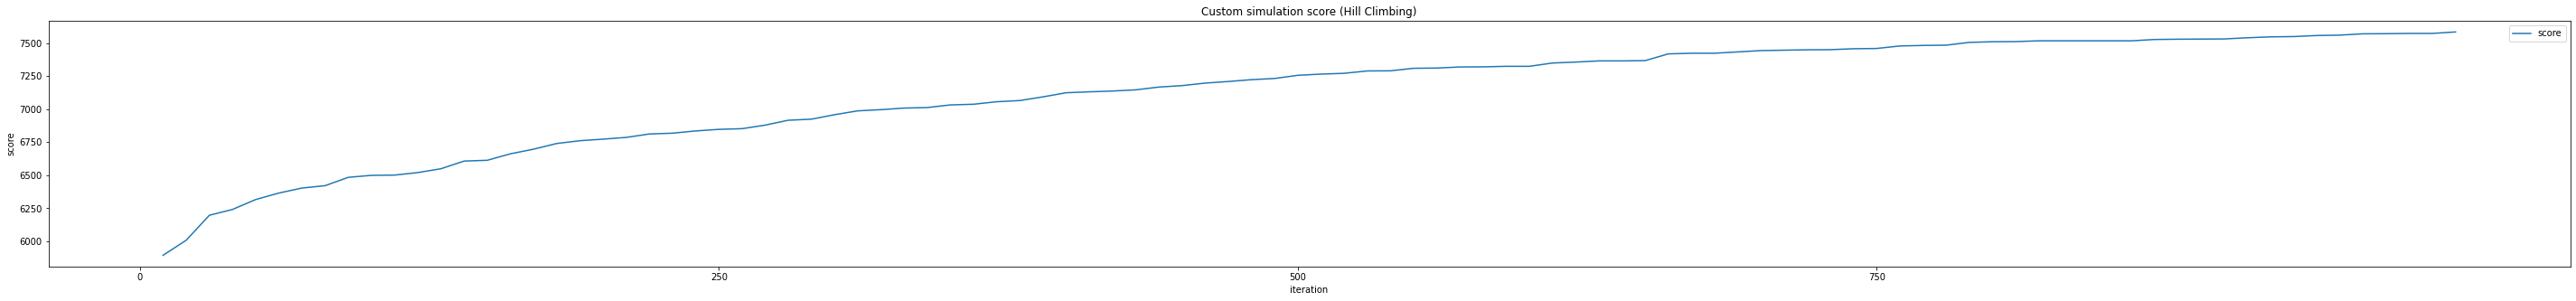

In [16]:
custom_simulation_hc_dataframe = read_results_file('results_36169.380528805.log')

custom_simulation_hc_iterations = list(custom_simulation_hc_dataframe.iloc[:,0])
custom_simulation_hc_score = list(custom_simulation_hc_dataframe.iloc[:,1])

x = custom_simulation_hc_iterations
y_list = [
    custom_simulation_hc_score,
]

x_label = 'iteration'
y_label = 'score'
line_labels = [
    'score',
]

plot_results(x, y_list, x_label, y_label, line_labels, plot_name='Custom simulation score (Hill Climbing)')